In [1]:
import cv2
import numpy as np 
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt 

(<AxesSubplot:title={'center':'Gray of Binary image'}>,
 Text(0.5, 1.0, 'Gray of Binary image'))

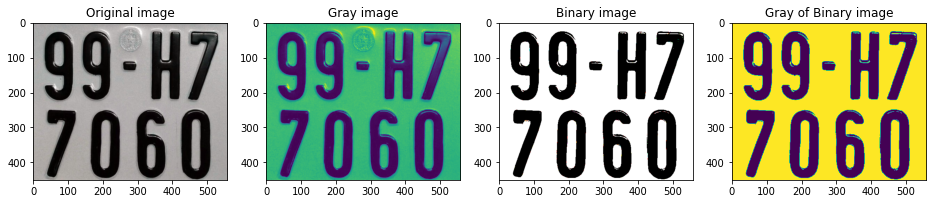

In [2]:
img = cv2.imread('Bienso.jpg')
#CHuyển ảnh sang image gray
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#CHuyển ảnh sang ảnh nhị phân
_, imgBi = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
#Chuyển ảnh sang grayimage
imgGrayBi = cv2.cvtColor(imgBi, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(16,4))
plt.subplot(141), plt.imshow(img), plt.title('Original image')
plt.subplot(142), plt.imshow(imgGray), plt.title('Gray image')
plt.subplot(143), plt. imshow(imgBi), plt.title('Binary image')
plt.subplot(144), plt.imshow(imgGrayBi), plt.title('Gray of Binary image')

In [3]:
contours, hierarchy = cv2.findContours(imgGrayBi, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#Sắp xếp các contour theo diện tích giảm dần:
area_cnt = [cv2.contourArea(cnt) for cnt in contours]
area_sort = np.argsort(area_cnt)[::-1]
#Top 20 contours có diện tích lớn nhất
area_sort[:20]

array([ 0, 24, 20, 49, 12, 61, 45, 36, 53, 21, 29, 51, 63, 14, 39,  3, 60,
       46, 59, 62], dtype=int64)

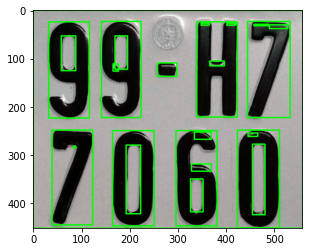

In [10]:
def _drawBoundingbox(img, cnt):
    x, y, w, h = cv2.boundingRect(cnt)
    tmg = cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
    return img

imgOrigin = img.copy()
#Vẽ bounding box cho 25 contours cps diện tích lớn nhất
for i in area_sort[:25]:
    cnt = contours[i]
    imgOrigin = _drawBoundingbox(imgOrigin, cnt)
plt.imshow(imgOrigin)



In [13]:
import numpy as np 
def non_max_suppression(boxes, overlapThresh):
    '''
    boxes: list các bounding box
    pverlapThresh: Ngưỡng overflapping giữa các hình ảnh
    '''
    #Nếu không có bounding box thì trả về empty list"
    if len(boxes) == 0:
        return []
    
    #Nếu bounding boxes nguyên thì chuyển sang float
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    
    #KHởi tạo list của các index được lựa chọn
    pick = []

    #Lấy ra tọa độ của các bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    #Tính toán diện tích các bounding boxes và sắp xếp chúng theo thứ tự từ bottomm-right, chính là tọa độ theo y của bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # Khởi tạo 1 còng while loop qua các index xuất hiện trong indexes
    while len(idxs) > 0:
        # Lấy ra index cuối cùng của list các indexes và thêm giá trị index vào danh sách các indexes được lựa chọn
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        #Timg cặp tọa đọ lớn nhất (x, y) là điểm bắt đầu của bounding box và tọa độ nhỏ nhất (x,y) là điểm kết thúc của bounding box":
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        #Tính toán các width height của bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        #Tính toán tỉ lệ diện tích overflap
        overlap = (w*h) / area[idxs[:last]]

        #Xóa index cuối cùng và index của bounding box mà tỉ lệ dien tích overlap > overlapThreshold
        idxs = np.delete(idxs, np.concatenate(([last], 
                np.where(overlap > overlapThresh)[0])))
    #Trả ra list index được chọn
    return boxes[pick].astype("int")

boundingBoxes = [cv2.boundingRect(cnt) for cnt in contours]
boundingBoxes = np.array([(x,y,x+w,y+h) for (x,y,w,h) in boundingBoxes])
pick = non_max_suppression(boundingBoxes, 0.5)

In [14]:
x,y,w,h = cv2.boundingRect(cnt)

#Vẽ bounding box cho 25 contours có diện tích lớn nhất:
boundingBoxes = []
for i in area_sort[:25]:
    cnt = contours[i]
    x,y,w,h = cv2.boundingRect(cnt)
    x1, y1, x2, y2 = x, y, x+w, y+h
    boundingBoxes.append((x1, y1, x2, y2))

# Remove đi bounding box parent (chính là khung hình bound toàn bộ hình ảnh), nếu không khi áp dụng non max suppression chỉ giữ lại bounding box này
boundingBoxes = [box for box in boundingBoxes if box[:2] != (0, 0)]
boundingBoxes = np.array(boundingBoxes)
pick = non_max_suppression(boundingBoxes, 0.5)


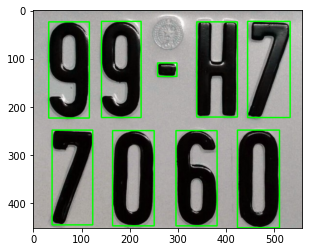

In [15]:
imgOrigin = img.copy()
for (startX, startY, endX, endY) in pick:
    imgOrigin = cv2.rectangle(imgOrigin, (startX, startY), (endX, endY), (0, 255, 0), 2)
plt.imshow(imgOrigin)

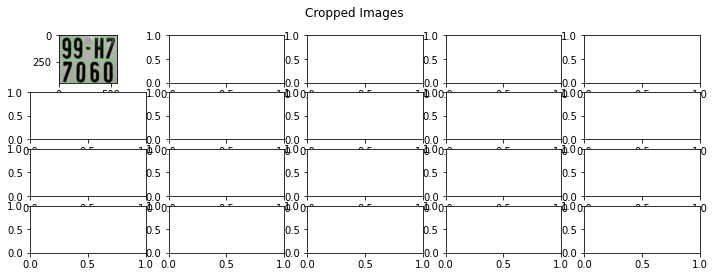

In [4]:
def _cropImage(x1, y1, x2, y2, img):
  if np.ndim(img) == 3:
    crop = img[y1:y2, x1:x2, :]
  else:
    crop = img[y1:y2, x1:x2]
  return crop

crop_images = [_cropImage(x1, y1, x2, y2, imgOrigin) for (x1, y1, x2, y2) in pick]

fg, ax = plt.subplots(4,5,figsize=(12, 4))
fg.suptitle('Cropped Images')

for i in np.arange(4):
  for j in np.arange(5):
    try:
      ax[i,j].imshow(crop_images[i+j+j*i])
      ax[i,j].set_xlabel('Sub Image '+str(i+j+j*i))
    except:
      next